In [23]:
# Import module
import os
import clip
import glob
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
data_dir = 'dataset/seg'
all_img_path = dict()
for folder in os.listdir(data_dir):
    all_img_path[folder] = glob.glob(os.path.join(data_dir, folder, '*.jpg'))

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [10]:
bs = 20
save_dir = './CLIP_features'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for label, img_paths in all_img_path.items():
    all_features = []
    for i in tqdm(range(0, len(img_paths), bs)):
        batch_imgs = [preprocess(Image.open(p).convert("RGB")).unsqueeze(0) for p in img_paths[i:i+bs]]
        batch_imgs = torch.cat(batch_imgs).to(device)

        with torch.no_grad():
            image_features = model.encode_image(batch_imgs)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        
        for b in range(image_features.shape[0]):
            all_features.append(image_features[b].cpu().numpy().astype(np.float32).flatten())

    np.save(os.path.join(save_dir, f'{label}_features.npy'), np.array(all_features))

100%|██████████| 120/120 [00:07<00:00, 15.50it/s]


In [16]:
import faiss
feature_shape = 512
feature_dir = './CLIP_features'
index = faiss.IndexFlatL2(feature_shape)

for feature_file in os.listdir(feature_dir):
    features = np.load(os.path.join(feature_dir, feature_file))
    for feat in features:
        index.add(feat.astype(np.float32).reshape(1, -1))
faiss.write_index(index, 'faiss_clip.bin')

In [17]:
class myFaiss:
    def __init__(self, bin_clip_file = "faiss_clip.bin", feature_shape=512):
        self.index_clip = self.load_bin_file(bin_clip_file)
        self.clip_model = clip.load("ViT-B/32", device=device)[0]
        self.__device = "cuda" if torch.cuda.is_available() else "cpu"

    def load_bin_file(self, bin_file):
        return faiss.read_index(bin_file)
    def image_search(self, img, top_k=5):
        img = preprocess(img).unsqueeze(0).to(self.__device)
        with torch.no_grad():
            image_features = self.clip_model.encode_image(img)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.cpu().numpy().astype(np.float32)
        scores , idx_image = self.index_clip.search(image_features, top_k)
        idx_image = idx_image.flatten()
        scores = scores.flatten()
        return scores , idx_image
   


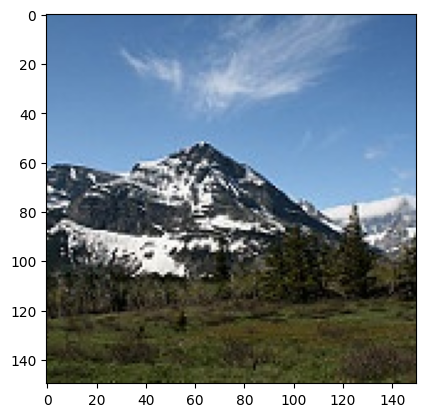

In [26]:
img  = Image.open('dataset/seg_test/mountain/20107.jpg').convert("RGB")
plt.imshow(img)

In [27]:
import faiss
faiss = myFaiss()
img  = Image.open('dataset/seg_test/mountain/20107.jpg').convert("RGB")
scores, idxs = faiss.image_search(img, top_k=5)
print("Scores: ", scores)
import os
print("Index: ", idxs)
print("Image paths: ")


Scores:  [0.08868025 0.10575123 0.10822791 0.11989386 0.12509558]
Index:  [8659 7970 8994 8531 7224]
Image paths: 


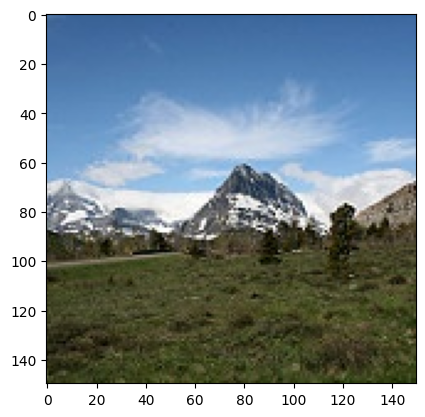

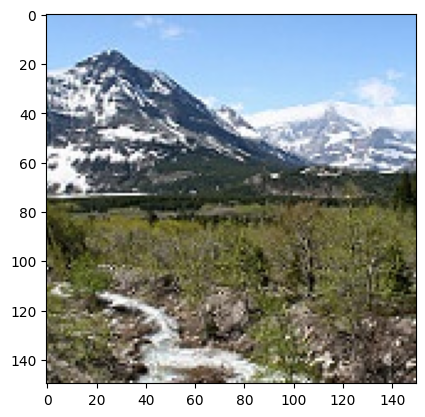

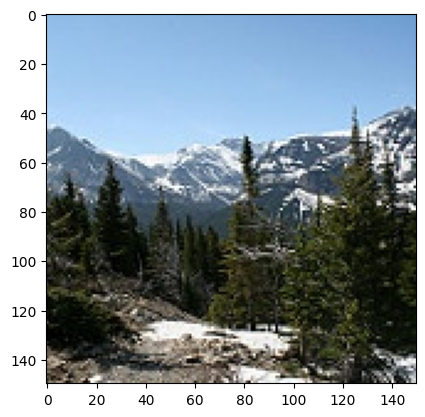

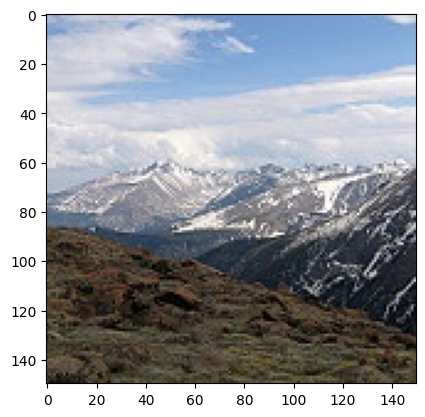

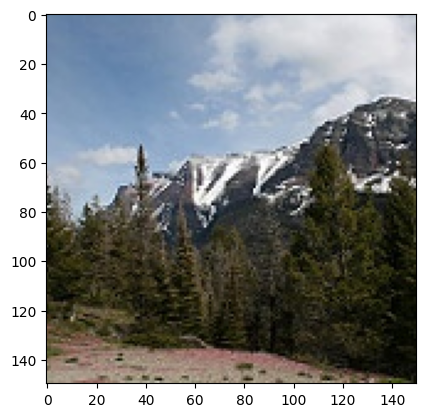

In [28]:
for idx in idxs:
    for folder in os.listdir(data_dir):
        img_paths = glob.glob(os.path.join(data_dir, folder, '*.jpg'))
        if idx < len(img_paths):
            plt.imshow(Image.open(img_paths[idx]).convert("RGB"))
            plt.show()
            break
        else:
            idx -= len(img_paths)